### Gather Tutorial

This tutorial shows the common usage of the Gather class, a simple representing of seismic gather. <br>
Gather Tutorial notebook will get you acquanted with the Gather creation and base seismic data processing, shows common attributes and methods.

### Content

[Introduction](#Introduction) <br>
[Creating Gather](#Creating-Gather) <br>
[Attributes](#Attributes) <br>
[General Methods](#General-Methods)<br>
[Normalization Methods](#Normalization-Methods) <br>
[Muting Methods](#Muting-Methods) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys # delete after finish
sys.path.append('..') # delete after finish

import matplotlib.pyplot as plt

from seismicpro import Survey, Muter

/// функция нужна в блоке про нормализации

1. сделать отдельной функцией и вставить в начало файла
2. сделать отдельной функцией и вынести в utils

In [2]:
def histogram_plotter(gather_list, bins=41):
    n_plots = len(gather_list)
    fig, ax = plt.subplots(1, n_plots, figsize=(6 * n_plots, 4))
    for i in range(n_plots):
        ax[i].set_title(gather_list[i][1])
        _ = ax[i].hist(gather_list[i][0].data.ravel(), bins=bins)

### Introduction

We use `Survey` class to make a concise image of the SEG-Y file. `Survey` keeps headers but doesn't load the trace data. For working with trace data, we use the `Gather` class. <br>
`Gather` contains the trace data collected by the same index value, and a subset of `Survey`'s headers corresponded with traces.

Relation `Survey` and `Gather` better understand with the picture below.<br>
We create the `Survey` instance with FieldRecord in `header_index` and 'TraceNumber', 'offset', 'CDP' in `header_cols`. <br>
When we create `Gather` instance with the FieldRecord equal to 912, `Gather` takes all trace data with the same FieldRecord from the parent SEG-Y file and takes the `headers` subset from the `Survey`.

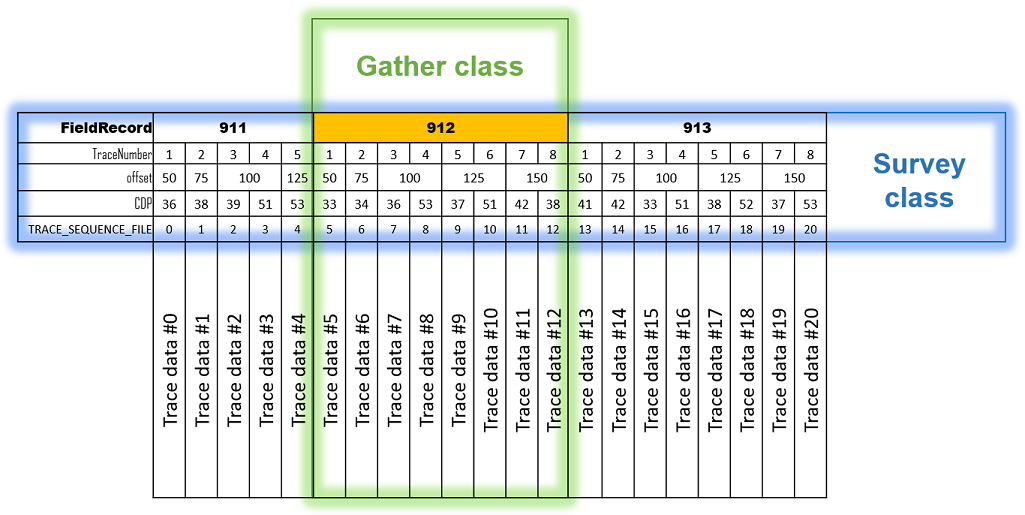

Why don't we load trace data in the `Survey` class? <br>
SEG-Y files are usually very-very huge. A better way is to work with the meaningful chunk that `Gather` class makes. 

### Creating Gather
You will get to know two methods of creating a Gather instance and learn about Gather structure.

We need to create the Survey class first.

In [3]:
sgy_path = './data/small_survey.sgy'
header_cols = ["TraceNumber", "offset", 'CDP']
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=header_cols, collect_stats=True) # collect_stats needs for normalization block

Calculating statistics for survey small_survey:   0%|          | 0/8640 [00:00<?, ?it/s]

#### get_gather()

To create the Gather with the Survey's method `get_gather()` we need specify `header_index`'s value. Gather extract a trace data with indicated trace header value only. <br>

In [4]:
survey.headers

,TraceNumber,offset,CDP,TRACE_SEQUENCE_FILE
FieldRecord,,,,
111916,1656,127,2130094,5185
111916,195,3304,2050513,6344
111916,1304,3303,2114118,6343
111916,1578,3301,2122204,6342
111916,1447,3301,2122073,6341
...,...,...,...,...
111920,661,2310,2074427,4027
111920,818,2308,2082396,4026
111920,767,2308,2082345,4025


Now choose any value from <b>FieldRecord</b> columns and specify it in `get_gather()` method. 

In [5]:
gather = survey.get_gather(index=111920)

Now see information about created gather with `info()` method.

In [6]:
gather.info()


Parent survey path:          ./data/small_survey.sgy
Parent survey name:          small_survey

Number of traces:            1728
Trace length:                3000 samples
Sample rate:                 2.0 ms
Times range:                 [0.0 ms, 5998.0 ms]
Offsets range:               [127 m, 4949 m]

Index name(s):               FieldRecord
Index value:                 111920
Gather sorting:              None

Gather statistics:
Number of dead traces:       2
mean | std:                        0.00 | 0.49      
 min | max:                      -19.68 | 27.05     
 q01 | q99:                       -1.48 | 1.49      



`info()` returns detail information about the `Gather` instance. <br> 

/// тут затыка у меня. Т.к. сказать что-то о самой информации надо, подробный рассказ зарезали, а отдельные предложения из него выглядят вырванными из контекста и не выглядят связным рассказом.

The `Gather` keep info about parent `Survey` and SEG-Y file. 
Traces in `Gather` indexed by 'FieldRecord' and have the FieldRecord value is 111920 only.
Gather statistics shows common information about all trace data loaded by the `Gather` and auto-calculated when `info()` called.

<b> Notes: </b>
When Gather is created from the Survey with limits, traces will be loaded within specified limits.

#### sample_gather()

`sample_gather()` create the Gather same as `get_gather()` with a one randomly chosen index value.

`gather = survey.sample_gather()`

### Attributes

Let discuss useful attributes of the Gather class.

<b>`headers`</b> - `pandas.Dataframe` containing the subset of the parent `Survey`'s headers with index value defined due to the Gather creation.

In [7]:
gather.headers

,TraceNumber,offset,CDP,TRACE_SEQUENCE_FILE
FieldRecord,,,,
111920,1,4949,2042519,5183
111920,1656,127,2130106,3457
111920,195,3303,2050525,4615
111920,1447,3301,2122085,4614
111920,1141,3301,2098343,4613
...,...,...,...,...
111920,661,2310,2074427,4027
111920,818,2308,2082396,4026
111920,767,2308,2082345,4025


`headers` Dataframe indexed by FieldRecord. Indexing is specified with Survey creation and can't be changed via the Gather.

<b>`data`</b> - `numpy.array` containing the trace data of all traces in Gather.

In [8]:
gather.data

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.6814188e-05, -5.5691853e-05, -8.2191476e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  2.0864907e-11, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  4.3150834e-09, -3.0650416e-08, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

You could check the shape of the `data` array and make certain that the shape of the array is (`Number of traces`, `Trace length`)

In [9]:
gather.data.shape

(1728, 3000)

<b>`samples`</b> - an array of record timestamps, ms

In [10]:
gather.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 5.994e+03, 5.996e+03,
       5.998e+03], dtype=float32)

<b>`sample_rate` </b> - sample interval for each trace, ms

In [11]:
gather.sample_rate

2.0

We learned about the main attributes of the Gather class.

### General Methods

We'll talk about common methods in this block.

#### <i>plot() </i>

`plot()` method use for visualization trace data information.

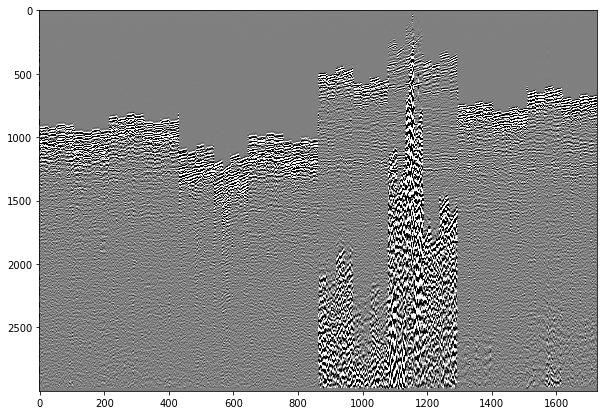

In [12]:
gather.plot()

The Y-axis of the plot corresponds to samples and the X-axis to trace numbers. <br>
Gray color map means that the bigger value is black, lower is white. # оставить пока не допилят colorbar

Plotted seismogram looks rough in case `Gather` doesn't sort.

#### <i>sort() </i>

Sort the traces in the Gather by the `header_cols` value.<br>
`sort` works in the ascending order always.

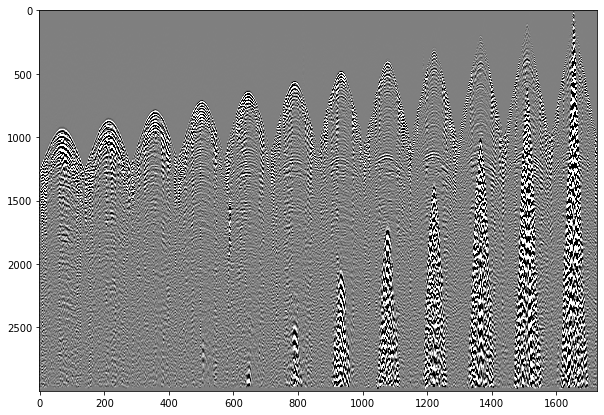

In [13]:
gather = survey.sample_gather().sort(by='TraceNumber')
gather.plot()

We could use `sort_by` attribute to check current sorting.

In [14]:
gather.sort_by

'TraceNumber'

#### <i>copy() </i>

Make the `Gather` copy.

Most the `Gather`'s methods change the Gather's data inplace. Using `copy()` and work with the copied Gather keeps the original `Gather` is safe.

Now we work with the `Gather` instance, sorted by 'TraceNumber' in the sort block. Make a copy of this `Gather` and sort the original `Gather` by 'offset'.

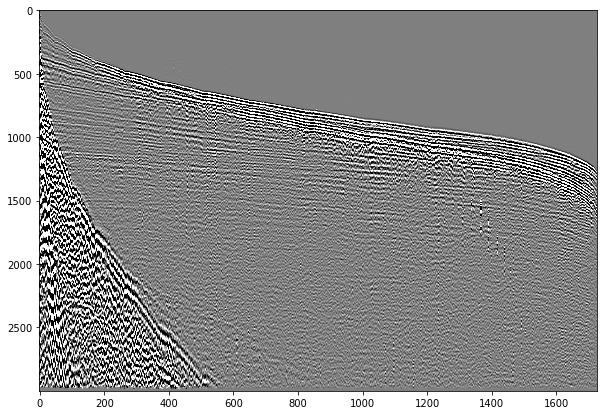

In [15]:
gather_copy = gather.copy()
gather.sort(by='offset')
gather.plot()

Now plot the copied Gather and shows that copied Gather is still sorted by `TraceNumber`.

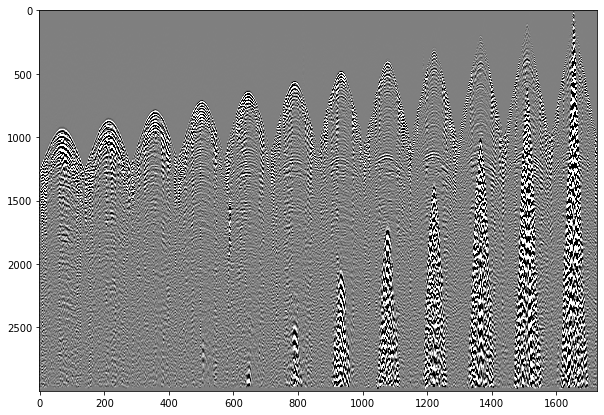

In [16]:
gather_copy.plot()

#### <i>dump() </i>

Save the `Gather` as a file in SEG-Y format on the disk. <br>

In [17]:
gather.dump(path='./data/', name='test_gather')

`path` specified directory for saved files and `name` of the SEG-Y file

By default, the saved file will contain the trace headers from `gather.headers` only. Suppose you could save other trace headers from parent SEG-Y with `copy_header=True`.<br>
`gather.dump(path='./data/', name='test_gather', copy_header=True)`

### Normalization Methods

Normalization methods are scaling `Gather`'s data.<br>

Normalization  methods have three options which define with `tracewise` and `use_global` flags.
1. The normalization parameters calculate by the separate trace with `tracewise=True` and `use_global=False`. This mode is used by default and no need to specified any params.
2. The normalization parameters take from global statistics of the Survey with `tracewise=False` and `use_global=True` and need to calculate the Survey's statistic first .
3. The normalization parameters calculate by all Gather's trace data with `tracewise=False` and `use_global=False`.

Reminder: methods work inplace. Use the copy method to save the original data unchanged.

#### <i>scale_standard() </i>

Normalize the gather data by moving mean to zero and variance to one.

In [18]:
gather_scaled = gather.copy()
gather_scaled.scale_standard()

print(f'Mean of the raw trace data is {gather.data.mean():.2f}')
print(f'Mean of the scaled trace data is {gather_scaled.data.mean():.2f}\n') # add abs() to remove the minus sign
print(f'Standard deviation of the raw trace data is {gather.data.std():.2f}')
print(f'Standard deviation of the scaled trace data is {gather_scaled.data.std():.2f}')

Mean of the raw trace data is 0.00
Mean of the scaled trace data is -0.00

Standard deviation of the raw trace data is 0.51
Standard deviation of the scaled trace data is 1.00


All normalization methods have `use_global` flag. In this way, normalization parameters will take from the Survey and need to collect Survey's stats first.
Look at this on the `scale_standard()` case.

In [19]:
gather_scaled = gather.copy()
gather_scaled.scale_standard(use_global=True)

print(f'The Survey mean is {survey.mean:.2f}')
print(f'Mean of the Gather scaled trace data is {gather_scaled.data.mean():.2f}\n')
print(f'The Survey standard deviation is {survey.std:.2f}')
print(f"Standard deviation of the scaled Gather's trace data is {gather_scaled.data.std():.2f}")

The Survey mean is 0.00
Mean of the Gather scaled trace data is 0.00

The Survey standard deviation is 0.54
Standard deviation of the scaled Gather's trace data is 0.96


Survey's standard deviation is more than the Gather's standard deviation. As a result, `scale_standard()` with `use_global` dawn the standard deviation of the Gather's trace data from one.

#### <i>scale_maxabs() </i>

Normalize the gather data by the maximum absolute value.

In [20]:
gather_scaled = gather.copy()

gather_scaled.scale_maxabs()
print(f'Absolute minimum of the scaled trace data is {gather_scaled.data.min():.2f}')
print(f'Absolute maximum of the scaled trace data is {gather_scaled.data.max():.2f}')

Absolute minimum of the scaled trace data is -1.00
Absolute maximum of the scaled trace data is 1.00


Data outliers have a strong effect on the `scale_maxabs()` normalization. We may change it with `q_min` and `q_max` parameters. <br>
`q_min` and `q_max` are quantiles used as minimum and maximum instead absolute minimum and maximum. ata outliers have a strong effect on the scale_maxabs() normalization. We may change it with q_min and q_max parameters.
q_min and q_max are quantiles used as minimum and maximum instead of absolute minimum and maximum.

In [21]:
gather_scaled_quantile = gather.copy()
_ = gather_scaled_quantile.scale_maxabs(q_min=0.02, q_max=0.98)

Data distribution is better now near zero, but the data outlier remained. We could fix it with the `clip` parameters. 

In [22]:
gather_scaled_clip = gather.copy()
_ = gather_scaled_clip.scale_maxabs(q_min=0.02, q_max=0.98, clip=True)

Data smaller than -1 becomes -1, and data larger than 1 becomes 1.<br>

Normalization methods work with all trace data. Try to clarify `scale_maxabs()` with four histograms.<br>
1. Raw data.
2. `scale_maxabs()` without parameters.
3. `scale_maxabs()` with quantiles.
4. `scale_maxabs()` with quantiles and clip.

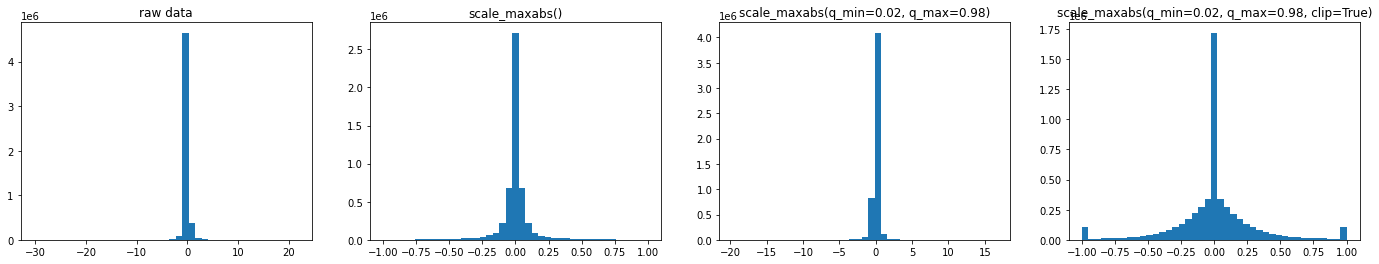

In [23]:
gather_list = [[gather, 'raw data'],
               [gather_scaled, 'scale_maxabs()'],
               [gather_scaled_quantile, 'scale_maxabs(q_min=0.02, q_max=0.98)'],
               [gather_scaled_clip, 'scale_maxabs(q_min=0.02, q_max=0.98, clip=True)']]

histogram_plotter(gather_list)

`scale_maxabs()` affected from data outliers. Adding quantiles makes the histogram is narrow. Clipping removes data outlier and adds little peaks at -1 and 1.

#### <i>scale_minmax() </i>

Scale trace data to a [0, 1] interval.

In [24]:
gather_scaled = gather.copy()
_ = gather_scaled.scale_minmax()

`scale_minmax()` also support using quantile to reduce data outliers effects and support clipping

In [25]:
gather_scaled_quantile = gather.copy()
_ = gather_scaled_quantile.scale_minmax(q_min=0.02, q_max=0.98)

In [26]:
gather_scaled_clip = gather.copy()
_ = gather_scaled_clip.scale_minmax(q_min=0.02, q_max=0.98, clip=True)

Both are explained in the `scale_maxabs()` block.

We are using the identical four histograms to elucidate the `scale_minmax()` method.<br>
1. Raw data.
2. `scale_minmax()` without parameters.
3. `scale_minmax()` with quantiles.
4. `scale_minmax()` with quantiles and clip.

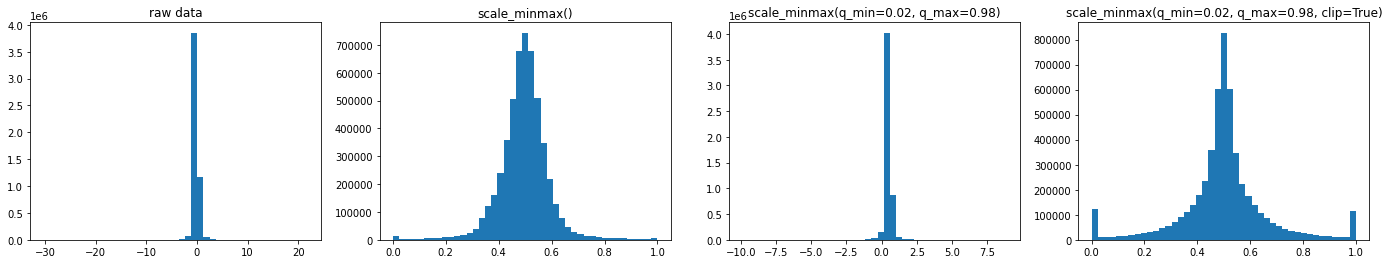

In [27]:
gather_list = [[gather, 'raw data'],
               [gather_scaled, 'scale_minmax()'],
               [gather_scaled_quantile, 'scale_minmax(q_min=0.02, q_max=0.98)'],
               [gather_scaled_clip, 'scale_minmax(q_min=0.02, q_max=0.98, clip=True)']]

histogram_plotter(gather_list, bins=43)

<b>get_quantile()</b><br> method returns the specified quantile for all trace `gather.get_quantile(0.01)` <br>
or quantile by each trace `gather.get_quantile(0.01, tracewise=True)`

<b>`get_quantile()`</b> is useful when you want to makes own normalization method. 

### Muting Methods

Muting is used to remove the noised trace data by nullification part of traces.

The `Muter` class implements muting processing. So, we need to create the `Muter` instance and apply `Muter` to `Gather` with the `mute()` method. <br>
Muter could be constructed from points, from a file, and by first breaks. Consider in detail muting from points.

For example, try to mute the trace data placed higher on a seismogram than a zigzag line. To begin, set the coordinates of the breakpoints and create `Muter` via the `from_point()` method.<br>
We specified four breakpoints in the samples below. Coordinates of these points are designate by offset and times separately.

In [28]:
gather_muted = gather.copy()
offsets = [127, 1500, 3000, 4949]
times = [400, 1200, 2200, 3300]
muter = Muter.from_points(offsets=offsets, times=times)

When the Muter is created, just apply it and watch what happens.

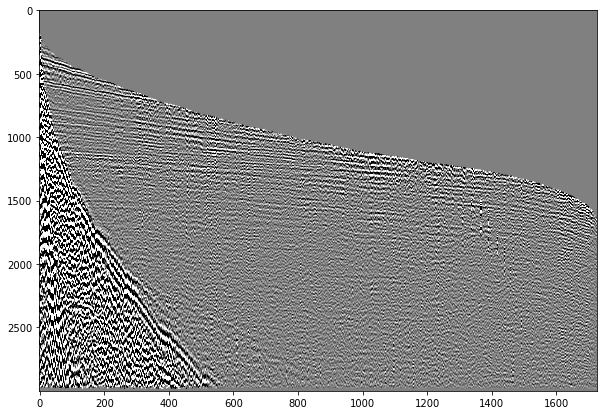

In [29]:
gather_muted.mute(muter)
gather_muted.plot()

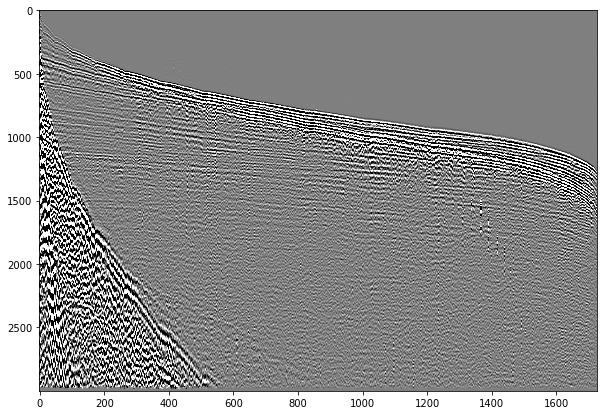

In [30]:
gather.plot()

We show only one mode of muting in this tutorial. To get more information about `first_breaks` and `file` modes, read SeismicPro [documentation].

### Conclusion

This tutorial:
- explained the purpose of the `Gather` class and showed a common using way.
- discussed `Gather`'s attributes with the containing results.
- showed `Gather`'s methods with visualizing its results.

To learn more, please refer to the [documentation]().
If you still have any questions you could free contact with our team by [...].

[Go to top](#Gather-Tutorial)